In [1]:
import os
import math
import glob
import numpy as np
import imageio

In [2]:
import copy

In [3]:
import matplotlib.pyplot as plt

In [4]:
from matplotlib import patches as mpl_patches

### Functions

In [5]:
def img_sort(img1, img2):
    """
    sort image data
    img1: target img (y=+1)
    img2: background img (y=-1)
    """
    def sort_index(n1=100, n2=100):
        clabel = np.array([i for i in range(n1+n2)])
        return np.random.permutation(clabel)
    img_list = []
    label_list = []
    n1 = len(img1)
    n2 = len(img2)
    label_idx = sort_index(n1=n1, n2=n2)
    for i in label_idx:
        if i < n1:
            img_list.append(img1[i])
            label_list+=[1]
        elif i >= n1:
            img_list.append(img2[i-n1])
            label_list+=[-1]
    imgs = np.asarray(img_list)
    labels = np.asarray(label_list)
    return imgs, labels

In [6]:
def load_data(faces_dir=[], background_dir=[]):
    def gen_filelist(filedir='', keyward=''):
        return glob.glob(filedir+'/*'+keyward+'*.jpg')
    def img_preprocess(filedir=''):
        im = imageio.imread(filedir)
        gray_scale = im.mean(axis=2)
        return gray_scale
    # filelist
    faces = gen_filelist(filedir=faces_dir)
    backgrounds = gen_filelist(filedir=background_dir)

    _fimgs = []
    _bimgs = []
    for ifile in faces:
        _fimgs += [img_preprocess(ifile).reshape(1,64,64)]
    for jfile in backgrounds:
        _bimgs += [img_preprocess(jfile).reshape(1,64,64)]

    _imgs, labels = img_sort(_fimgs,_bimgs)
    imgs = np.concatenate(_imgs, axis=0)

    #TODO: This two lines are bug
    #imgs = np.concatenate(_fimgs+_bimgs, axis=0)
    #labels = np.concatenate( (np.ones(len(_fimgs)),np.ones(len(_bimgs))) )
    return imgs, labels

In [7]:
def compute_integral_image(imgs):
    """
    IN: imgs. np.ndarray, shape [#images, 64,64]
    """

    def _compute_int_img_unit(img):
        """
            compute integral image for one image
        """
        nx, ny = img.shape
        int_img = np.ones((nx,ny))
        int_img[0,0] = img[0,0]
        for i in range(nx):
            for j in range(ny):
                if j > 0 and i > 0:
                    int_img[i,j] = int_img[i-1,j] + sum([ img[i,k] for k in range(j+1)])
                elif j==0 and i>0:
                    int_img[i,0] = int_img[i-1,0] + img[i,0]
                elif i==0 and j>0:
                    int_img[0,j] = int_img[0,j-1] + img[0,j]
        return int_img

    nimg, nx, ny = imgs.shape
    int_img_list = []
    for img in imgs:
        int_img_list += [_compute_int_img_unit(img).reshape(1,nx,ny)]
    int_imgs = np.concatenate(int_img_list, axis=0)
    return int_imgs


In [8]:
def feature_list(nx=64,ny=64,height=2,width=1,stride=1):
    f12_list = []
    f21_list = []
    for j in range(0,ny,stride):
        for i in range(0,nx, stride):
            ### 1 by 2 (x by y)
            if i+stride+width <= nx-1 and j+height <= ny-1:
                #shaded
                xs, ys  = i,j # upper left
                _xs,_ys = i+width, j+height# bottom right
                # unshaded
                xu, yu  = i+stride,j # upper left
                _xu,_yu = i+stride+width, j+height# bottom right
                # shaded + unshaded
                f12_list += [[[xs, ys],[_xs, _ys],[xu, yu],[_xu, _yu]]]
            ### 2 by 1 (x by y)
            if i+stride+width <= nx-1 and j+stride+width <= ny-1:
                #shaded
                xs, ys  = i,j # upper left
                _xs,_ys = i+height, j+width# bottom right
                # unshaded
                xu, yu  = i,j+stride # upper left
                _xu,_yu = i+height, j+stride+width# bottom right
                # shaded + unshaded
                f21_list += [[[xs, ys],[_xs, _ys],[xu, yu],[_xu, _yu]]]
    return f12_list+f21_list


In [9]:
def compute_feature(int_img_rep, feat_lst, feat_idx):
    """ int_img_rep: the N x 64 x 64 numpy matrix of the integral image representation
        feat_lst: list of features
        feat_idx: integer, index of a feature (in feat_lst)
        Returns: an N x 1 numpy matrix of the feature evaluations for each image
    """
    n, nx, ny = int_img_rep.shape
    feat_eval = []

    def _compute_intensity(int_img, ul, rb):
        """
        compute intensity
        x: upper left [ix, jx]
        y: bottom right [iy, jy]

        *(ix,iy)---*
        |          |
        |          |
        *----------*(jx,jy)
        """
        ix, iy = ul # upper left x,y
        jx, jy = rb #  bottom right x, y
        if ix-1 >= 0 and iy-1 >= 0  :
            intensity = int_img[jx,jy] + int_img[ix-1,iy-1] - int_img[ix-1,jy] - int_img[jx,iy-1]
        elif ix-1 >=0 and iy-1<0:
            intensity = int_img[jx,jy] - int_img[ix-1,jy]
        elif ix-1 < 0 and iy-1>=0:
            intensity = int_img[jx,jy]  - int_img[jx,iy-1]
        elif ix-1 < 0 and iy-1< 0:
            intensity = int_img[jx,jy]
        return intensity

    for img in int_img_rep:
        """
        x: upper left in shaded
        y: bottom right in shaded
        z: upper left in unshaded
        s: bottom right in unshaded
        """
        x,y,z,s = feat_lst[feat_idx]
        shaded   = _compute_intensity(img, x,y)
        unshaded = _compute_intensity(img, z,s)
        feat_eval +=[shaded - unshaded]

    return np.asarray(feat_eval)


In [10]:
def opt_p_theta(int_img_rep, feat_lst, weights, feat_idx, y_true):
    """
    p = {+1,-1}
    theta = threshold
    """
    p, theta = 0,0
    #value of feature_idx on example 1-All
    _eval_list = [] # f(x_sigma)
    _eval_list += [compute_feature(int_img_rep=int_img_rep, feat_lst=feat_lst, feat_idx=feat_idx)]
    #permutation
    _eval_list.sort() # f(x_sigma1) < f(x_sigma2) ... < f(x_sigmaN)
    eval_list = np.squeeze(np.asarray(_eval_list))
    #print(eval_list.shape)

    #potential theta
    thetas = []
    for i in range(int_img_rep.shape[0]):
        theta_left = eval_list[i]
        if i+1 <= len(eval_list)-1:
            theta_right = eval_list[i+1]
        else:
            theta_right = theta_left

        # decide theta
        """
         f(x_sigma_j) <= theta <= f(x_sigma_j+1) j:= feat_idx
        """
        theta = theta_left + (theta_right-theta_left)/2
        thetas += [theta]

    #decide p
    ps = []
    plus_vec  = np.zeros(len(y_true))## length is y_true
    minus_vec = np.zeros(len(y_true))
    plus_vec[np.where(y_true == 1)] = 1 # binary vector
    minus_vec[np.where(y_true == -1)] = 1

    prod_plus = weights*plus_vec
    prod_minus = weights*minus_vec

    t_plus = np.sum(prod_plus)
    t_minus = np.sum(prod_minus)
    for i in range(int_img_rep.shape[0]):
        s_plus = np.sum(prod_plus[:i])
        s_minus = np.sum(prod_minus[:i])
        # Comment out lines are bug
        #epsilon = min((s_plus+(t_minus-s_minus)), (s_minus+(t_plus-s_plus)))
        #p = np.sign(epsilon)
        if s_plus+(t_minus-s_minus) < s_minus+(t_plus-s_plus):
            p = -1
        else:
            p = 1
        ps += [p]

    return np.asarray(ps), np.asarray(thetas)

In [11]:
def eval_learner(int_img_rep, feat_lst, feat_idx, p, theta):
    """
    int_img_rep: the N x 64 x 64 numpy matrix of the integral image representation
    feat_lst: list of features
    feat_idx: integer, index of the feature for this weak learner
    p: +1 or -1, polarity
    theta: float, threshold
    Returns: N x 1 vector of label predictions for the given weak learner
    """
    ones = np.ones((int_img_rep.shape[0]))
    feature_vec = compute_feature(int_img_rep=int_img_rep, feat_lst=feat_lst, feat_idx=feat_idx)
    return np.sign(p*(feature_vec - theta))

In [12]:
def error_rate(int_img_rep, feat_lst, weights, feat_idx, p, theta, y_true):
    """
    int_img_rep: the N x 64 x 64 numpy matrix of the integral image representation
    feat_lst: list of features
    weights: an N x 1 matrix containing the weights for each datapoint
    feat_idx: integer, index of the feature for this weak learner
    p: +1 or -1, polarity
    theta: float, threshold
    y_true: N x 1 matrix of true labels
    Returns: the weighted error rate of this weak learner
    """
    ### Weighted error of h_t
    """Classifier’s error rate.
        This is just the number of misclassifications over the training set
        divided by the training set size.
    """
    ## correctness: number of correctly classified data
    eval_vec = eval_learner(int_img_rep, feat_lst, feat_idx, p, theta)
    error_vec = np.asarray(list(map(lambda x: 1 if x != 0 else 0, (y_true-eval_vec))))
    weighted_error = weights*error_vec
    weighted_error_rate = np.sum(weighted_error)/int_img_rep.shape[0]
    return weighted_error_rate

In [13]:
def opt_weaklearner(int_img_rep, weights, feat_lst, y_true):
    """
    int_img_rep: the N x 64 x 64 numpy matrix of the integral image representation
    weights: N x 1 matrix of weights of each datapoint
    feat_lst: list of features
    Returns: the i (feature_idx), p, and theta values for the optimal weak learner
    """
    best_erate, best_feat_idx, best_p, best_theta =1.0e10, 0, 0, 0 # initialization
    for feat_idx in range(len(feat_lst)):
        p, theta = opt_p_theta(int_img_rep, feat_lst, weights, feat_idx, y_true)
        erate = error_rate(int_img_rep, feat_lst, weights, feat_idx, p, theta, y_true)
        if best_erate > erate:
            # update best error rate
            best_erate = erate
            best_feat_idx = feat_idx
            best_p = p
            best_theta = theta
    return best_feat_idx, best_p, best_theta

In [14]:
def update_weights(weights, _error_rate, y_pred, y_true):
    """
    weights: N x 1 matrix containing the weights of each datapoint
    error_rate: the weighted error rate
    y_pred: N x 1 matrix of predicted labels
    y_true: N x 1 matrix of true labels
    Returns: N x 1 matrix of the updated weights
    """
    # scaler params
    alpha = 0.5*math.log((1-_error_rate)/_error_rate)
    zt = 2*math.sqrt(_error_rate*(1-_error_rate))
    new_weights = np.zeros((weights.shape))
    for i in range(len(y_true)):
        new_weights[i] = weights[i]*math.exp(-1*alpha*y_true[i]*y_pred[i])/zt
    return new_weights

In [15]:
def evaluate_performance(y_pred, y_true):
    """
    FP: label "True" against actually "False" data
        e.g. False - True =  (-1) - 1
    """
    FP = np.asarray(list(map(lambda x: 1 if x == -2 else 0, (y_true-y_pred))))
    return np.sum(FP)/len(y_true)

In [16]:
def gen_init_weights(y_true):
    nface = len(np.argwhere( y_true == 1))
    nback = len(np.argwhere( y_true == -1))
    w = np.ones((len(y_true)))
    coef_face = 0.5/nface
    coef_back = 0.5/nback
    for idx, i in enumerate(y_true):
        if i > 0:
            w[idx] = w[idx]*coef_face
        else:
            w[idx] = w[idx]*coef_back
    return w

In [17]:
def cascade_operation(imgs, y_pred, w, y_true):
    new_imgs = []
    new_w = []
    new_y_true = []
    for i in range(len(y_pred)):
        if y_pred[i] == 1:
            new_imgs.append(imgs[i])
            new_w.append(w[i])
            new_y_true.append(y_true[i])
    return np.asarray(new_imgs), np.asarray(new_w), np.asarray(new_y_true)

In [50]:
def main_training(faces_datadir='./',
                  backg_datadir='./',
                  times = 100
  ):
    ### Load imgs & label
    imgs, y_true = load_data(faces_dir=faces_datadir,background_dir=backg_datadir)
    _, nx, ny = imgs.shape
    print( "###  Image Shape ###", imgs.shape)
    
    ### Integral Image
    int_imgs = compute_integral_image(imgs)
    
    ### Initial Weight
    w = gen_init_weights(y_true)

    ### Feature list
    flist = feature_list(nx=nx, ny=ny, stride=4, height=4, width=2)
    print( "###  Number of features ###", len(flist))
    
    ### Loop
    erate_list = []
    for it in range(3):
        best_feat_idx, best_p, best_theta = opt_weaklearner(int_imgs, w, flist, y_true)
        erate = error_rate(int_imgs, flist, w, best_feat_idx, best_p, best_theta, y_true)
        y_pred = eval_learner(int_imgs, flist, best_feat_idx, best_p, best_theta)
        w = update_weights(w, erate, y_pred, y_true)
        fp_rate = evaluate_performance(y_pred=y_pred, y_true=y_true)
        print(fp_rate)
        
        
        #update int_imgs
        imgs,w,y_true= cascade_operation(imgs, y_pred,w, y_true)
        int_imgs = compute_integral_image(imgs)    
        #print (true_idx, _y_true)
    return best_feat_idx, best_p, best_theta, erate, w

### Job Run

In [ ]:
imgs, best_idx = main_training(faces_datadir="./faces_test", backg_datadir= "./background_test")

In [ ]:
!ls /home/kurihana/class/MachineLearning_Kondor

In [51]:
feat_idx, p, theta,erate, w = main_training(faces_datadir="./faces_test", backg_datadir= "./background_test")

###  Image Shape ### (1302, 64, 64)
###  Number of features ### 450
0.17434715821812596
0.1458966565349544
0.09815950920245399


In [20]:
test_img = imageio.imread("./class.jpg")

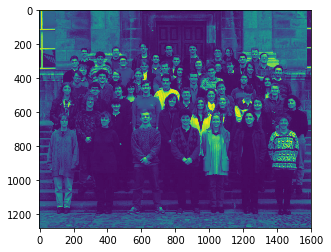

In [21]:
plt.imshow(test_img)

### Practice/Debug function

In [ ]:
a = np.array([1,1,1,1,-1])
b = np.array([-1,1,1,1,-1])
evaluate_performance(a,b)

In [ ]:
gen_init_weights(a)

In [ ]:
imgs.shape

In [ ]:
j = np.random.randint(0,650)
plt.figure()
plt.imshow(imgs[j])

In [ ]:
_, nx, ny = imgs.shape
flist = feature_list(nx=nx, ny=ny, stride=4, height=4, width=2)

In [ ]:
j = np.random.randint(0,649)
plt.figure()
ax = plt.subplot(111)
plt.imshow(imgs[j])
x,y,z,s = flist[best_idx]
ax.add_patch(mpl_patches.Rectangle(
    (x[0], x[1]),
    width = y[1] - x[1],
    height = y[0] - x[0],
    linewidth=1,
    edgecolor="black",
    facecolor='black'
    )
)
ax.add_patch(mpl_patches.Rectangle(
    (z[0], z[1]),
    width = s[1] - z[1],
    height = s[0] - z[0],
    linewidth=1,
    edgecolor="black",
    facecolor="none"
    )
)
plt.show()

### Test Patches

In [22]:
def gen_patches(img, stride=64, patch_size=64):
    windows = []
    nx, ny = img.shape
    for i in range(0, nx, stride):
        for j in range(0, ny, stride):
            if i + patch_size <= img.shape[0] and j + patch_size <= img.shape[1]:
                windows +=[img[i:i + patch_size, j:j + patch_size].astype(float)]
    return np.asarray(windows)

In [27]:
patches = gen_patches(test_img, stride=32)

In [28]:
patches.shape

(1911, 64, 64)

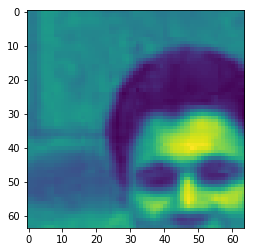

In [31]:
plt.imshow(patches[397])

In [33]:
test_int_patches = compute_integral_image(patches)

In [38]:
feat_idx, p.shape, theta.shape

(32, (321,), (321,))

In [ ]:
def get_test_error(classifier):
    for i in range(classifier):

In [58]:
def test(int_patches, feat_idx, p, theta,erate, w):
    _, nx, ny = int_patches.shape
    
    ### flist
    flist = feature_list(nx=nx, ny=ny, stride=4, height=4, width=2)
    a = eval_learner(int_patches[:len(p)], flist, feat_idx, p, theta)
    return a

In [59]:
a = test(test_int_patches, feat_idx, p, theta,erate, w)

In [60]:
a.shape

(326,)

In [69]:
a_idx = np.where(a == 1)

In [72]:
len(a_idx[0])

152

In [76]:
a_idx[0][100]

193

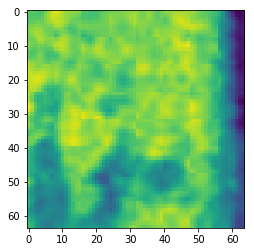

In [82]:
plt.imshow(patches[a_idx[0][121]])